In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
from datetime import datetime
import math
import copy
import os
from unet import UNet # We'll use the UNet that we implemented in the previous section (02-DDPM)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset

In [3]:
class AdjustPixelsRange(object):
    def __init__(self, range_in, range_out):
        self._range_in = torch.tensor(range_in, dtype=torch.float32)
        self._range_out = torch.tensor(range_out, dtype=torch.float32)

        if range_in == range_out:
            self.scale = 1
            self.bias = 0
        else:
            self.scale = (self._range_out[1] - self._range_out[0]) / (self._range_in[1] - self._range_in[0])
            self.bias = self._range_out[0] - self.scale * self._range_in[0]
    
    def __call__(self, x):
        return torch.clamp(self.scale * x + self.bias, min=self._range_out[0], max=self._range_out[1])

In [5]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../data/mnist', train=True, transform=transform, download=False)

## DDIM

$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}}$
$\Large \textcolor{cyan}{(\frac{x_t - \sqrt{1 - \bar{\alpha}_t} \epsilon^{(t)}_{\theta} (x_t)}{\sqrt{\bar{\alpha}_t}})}$
$+ \textcolor{#76FF03}{\sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \epsilon^{(t)}_{\theta} (x_t)}$
$+ \;\textcolor{#EA80FC}{\sigma_t \epsilon_t}$

$\textcolor{cyan}{\bullet}$ Predicted $x_0\;\;\;\;$
$\textcolor{#76FF03}{\bullet}$ direction pointing to $x_t\;\;\;\;$
$\textcolor{#EA80FC}{\bullet}$ random noise

$\sigma_t(\eta) = \eta \Large \sqrt{\frac{(1 - \bar{\alpha}_{t-1})}{(1 - \bar{\alpha}_t)}} \normalsize \sqrt{1 - \Large \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}}$

We consider $\Large \{ x_{\tau_1} , ... , x_{\tau_S} \}$ where $\tau$ is an increasing sub-sequence of $[1, ..., T]$ of length $S$

In [6]:
class DDIM:
    def __init__(self, T=1000, beta_1=1e-4, beta_T=2e-2, device='cpu'):
        self.device = device
        self.T = T

        betas = torch.linspace(beta_1, beta_T, steps=T, dtype=torch.double).to(device)
        betas = torch.cat([torch.zeros(1).to(device), betas], dim=0)
        self.shifted_alpha_bars = (1 - betas).cumprod(dim=0)

    def get_alpha_bars_t(self, t):
        return self.shifted_alpha_bars[t+1][:, None, None, None]
    
    def sample(self, x, model, sequence, eta=0):
        x_t = x
        for t, t_prev in zip(reversed(sequence), reversed([-1] + list(sequence[:-1]))):
            t, t_prev = [(torch.ones((x.shape[0], )) * val).long().to(self.device) for val in [t, t_prev]]

            abar_t, abar_tprev = self.get_alpha_bars_t(t), self.get_alpha_bars_t(t_prev)

            eps = model(x_t, t)
            sigma = eta * torch.sqrt((1 - abar_tprev) / (1 - abar_t)) * torch.sqrt(1 - abar_t/abar_tprev)

            # Blue Equation
            x0_pred = (x_t - torch.sqrt(1 - abar_t) * eps) / torch.sqrt(abar_t)
            first_term = torch.sqrt(abar_tprev) * x0_pred

            # Green Equation
            second_term = torch.sqrt(1 - abar_tprev - sigma**2) * eps

            # Pink Equation
            third_term = sigma * torch.randn_like(x)

            x_t = (first_term + second_term + third_term).float().detach()
        
        return x_t

            
    def sample_using_uniform_skip(self, x, model, num_steps=100, eta=0):
        sequence = list(range(0, self.T, self.T//num_steps))
        return self.sample(x, model, sequence, eta)

## Evaluation

In [8]:
ddim = DDIM(device='cuda')

model = UNet(
    img_channels=1,
    start_channels=64,
    channels_multiplier_arr=[1, 1, 2, 2],
    levels_to_apply_attention=[False, True, False, False],
    dropout_prob=0.1,
    num_resnet_blocks=2,
    max_time=ddim.T
).to(device)
model.load_state_dict(torch.load("../02-DDPM/mnist_results/model.pth"))
model.eval();

In [9]:
noise = torch.randn(64, 1, 32, 32).to(device)
generated_images_batch = ddim.sample_using_uniform_skip(
    x=noise,
    model=model,
    num_steps=20,
    eta=0
)

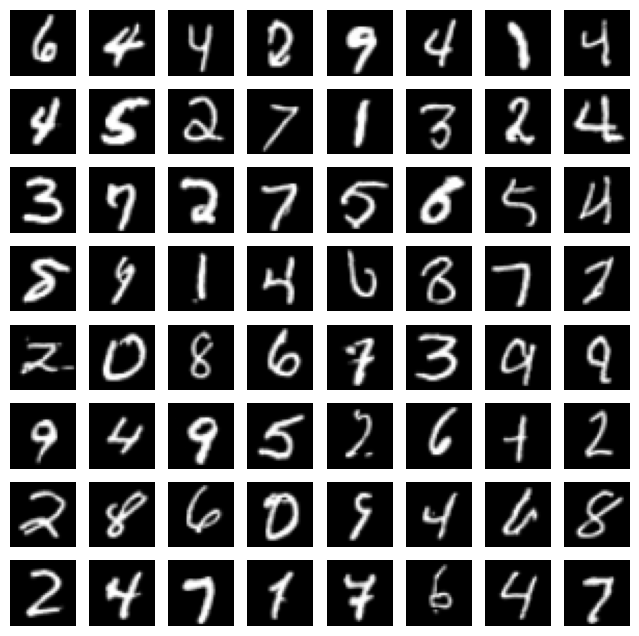

In [11]:
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
for i in range(64):
    axs[i//8][i%8].axis('off')
    axs[i//8][i%8].imshow(AdjustPixelsRange((-1, 1), (0, 1))(generated_images_batch[i].detach().cpu().permute(1, 2, 0)), cmap='gray')

### Interpolation

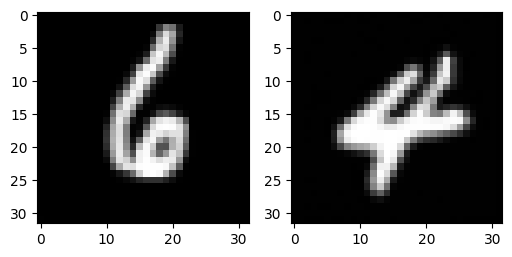

In [12]:
selected_indices = [0, 1]
selected_images = generated_images_batch[selected_indices]
selected_noise = noise[selected_indices]

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(selected_images[0].detach().cpu().permute(1, 2, 0), cmap='gray')
axs[1].imshow(selected_images[1].detach().cpu().permute(1, 2, 0), cmap='gray');

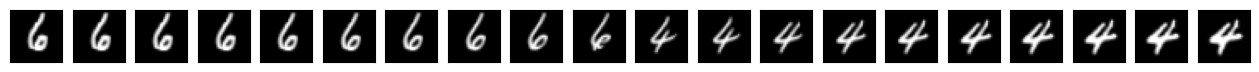

In [13]:
cnt = 20
percentage = torch.linspace(0, 1, cnt).view(cnt, 1, 1, 1).to(selected_noise.device)

fig, axs = plt.subplots(1, cnt, figsize=(16, 5))
intermediate_noise = selected_noise[0] * (1 - percentage) + selected_noise[1] * percentage
generated_from_interpolation = ddim.sample_using_uniform_skip(intermediate_noise, model=model, num_steps=100)

for j in range(cnt):
    axs[j].set_xticks([])
    axs[j].set_yticks([])
    axs[j].imshow(generated_from_interpolation[j].detach().cpu().permute(1, 2, 0), cmap='gray')

In [14]:
def slerp(z1, z2, alpha):
    theta = torch.acos(torch.sum(z1 * z2) / (torch.norm(z1) * torch.norm(z2)))
    return (
        torch.sin((1 - alpha) * theta) / torch.sin(theta) * z1
        + torch.sin(alpha * theta) / torch.sin(theta) * z2
    )

In [15]:
alpha = torch.arange(0.0, 1.01, 0.1).to(selected_noise[0].device)
z_ = []
for i in range(alpha.size(0)):
    z_.append(slerp(selected_noise[0].unsqueeze(1), selected_noise[1].unsqueeze(1), alpha[i]))
slerp_intermediate_noise = torch.cat(z_, dim=0)
slerp_intermediate_noise.shape

torch.Size([11, 1, 32, 32])

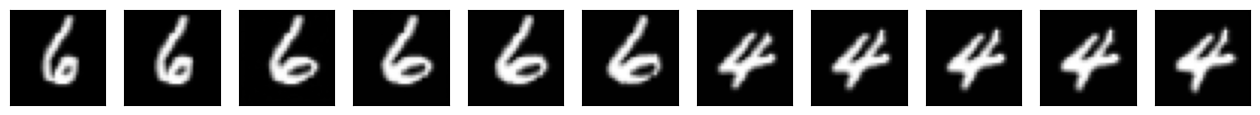

In [16]:
generated_from_interpolation = ddim.sample_using_uniform_skip(slerp_intermediate_noise, model=model, num_steps=100)

fig, axs = plt.subplots(1, slerp_intermediate_noise.shape[0], figsize=(16, 5))
for j in range(slerp_intermediate_noise.shape[0]):
    axs[j].set_xticks([])
    axs[j].set_yticks([])
    axs[j].imshow(generated_from_interpolation[j].detach().cpu().permute(1, 2, 0), cmap='gray')